<a href="https://colab.research.google.com/github/Kdavis2025/Projects/blob/main/Project%204%20-%20Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



# Business Case
The Music Popularity Prediction project aims to analyze historical data from songs that charted on Spotify’s Top 200 Weekly (Global) charts in 2020 and 2021. The goal is to develop a predictive model using tree-based regression techniques to estimate the popularity of a new song based on specific audio and metadata features.

# Data Science Problem Definition
Target (y): popularity (0–100 Spotify score).

Predictors (X): only those features available pre-release (i.e. numerical features + popularity (target).

Metrics:

1. Primary: **cross-validated RMSE (regression)**.

2. Secondary: feature importances to explain drivers of popularity.

Models to compare: **Decision Tree, Random Forest, XGBoost.**

Overfitting guardrails:

1. Cross-validation.
2. Hyperparameter tuning on tree depth, min samples per leaf, number of estimators.



# Overview of the data
1556 rows, 23 columns
Data Types: int64(3), object(20)
Data Size: 279.7+ KB



# Data Science Process



## Data Collection & Sources

Install & Import Packages

In [168]:
!pip install ace_tools_open # Install ace_tools_open package

In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from ace_tools_open import display_dataframe_to_user

Load Data

In [170]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url} # Check the URL is live:

HTTP/1.1 200 OK
x-amz-id-2: GKPHR+TdUlLmVRlRruYm2SuzfcJHdxe7XKc2ufgP+9kxU249e9BVtGg6gcVvYByePUhcK7+qC20=
x-amz-request-id: 5MEZHM59XXYW2WQY
Date: Fri, 25 Apr 2025 15:41:57 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [171]:
!curl -s -O {url} # Download the data:

In [172]:
ls -la # List files to verify:

total 740
drwxr-xr-x 1 root root   4096 Apr 25 11:56 ./
drwxr-xr-x 1 root root   4096 Apr 25 11:50 ../
drwxr-xr-x 4 root root   4096 Apr 23 13:39 .config/
drwxr-xr-x 1 root root   4096 Apr 23 13:39 sample_data/
-rw-r--r-- 1 root root 738124 Apr 25 15:41 Spotify.csv


In [173]:
!head -1 Spotify.csv | tr , '\n' | cat -n # Enumerate the header fields:

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [174]:
# Checking file size and properties
!ls -lh Spotify.csv


-rw-r--r-- 1 root root 721K Apr 25 15:41 Spotify.csv


### Data is loaded lets asign it to a dataframe for wrangling

In [175]:
# 1. Load
df = pd.read_csv("Spotify.csv")

# Quick look
print(df.shape)
print(df.info())
display(df.head())

(1556, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 1

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Define the Target

In [176]:
# 2. Explicitly set target column name
target = 'Popularity'
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna(subset=[target])

In [177]:
# 3. Convert only selected known numeric columns
numeric_features = [
    'Highest Charting Position', 'Number of Times Charted',
    'Streams', 'Artist Followers',
    'Danceability', 'Energy',  'Loudness', 'Speechiness',
    'Acousticness', 'Liveness', 'Tempo',
    'Duration (ms)', 'Valence'
]
for col in numeric_features:
    df[col] = df[col].astype(str).str.replace(',', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=numeric_features)

In [178]:
# 4. Display cleaned sample
display_dataframe_to_user('Cleaned Spotify Data', df[numeric_features + [target]].head())


Cleaned Spotify Data


## Data Processing

In [179]:
# 5. Prepare data and split
X = df[numeric_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [180]:
# 6. Define simplified hyperparameter grids (smaller search space)
models = {
    'Decision Tree': (
        DecisionTreeRegressor(random_state=42),
        {'max_depth': [10, 20], 'min_samples_split': [2, 10]}
    ),
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {'n_estimators': [100], 'max_depth': [10], 'min_samples_split': [2]}
    ),
    'XGBoost': (
        XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1),
        {'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.1]}
    )
}

## Modeling & CV

In [181]:
# 7. Run GridSearchCV with reduced CV folds and verbose output
results = {}
for name, (model, params) in models.items():
    grid = GridSearchCV(
        model, params,
        cv=3,               # fewer folds
        scoring='neg_mean_squared_error',
        verbose=1           # show progress
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    cv_rmse = np.sqrt(-grid.best_score_)
    y_pred = best.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred)
    results[name] = {
        'best_params': grid.best_params_,
        'cv_rmse': cv_rmse,
        'test_rmse': test_rmse
    }

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [182]:
# 8. Display model performance summary
res_df = pd.DataFrame(results).T
display_dataframe_to_user('Model Results (Simplified Grid)', res_df)

Model Results (Simplified Grid)


## Feature Importance

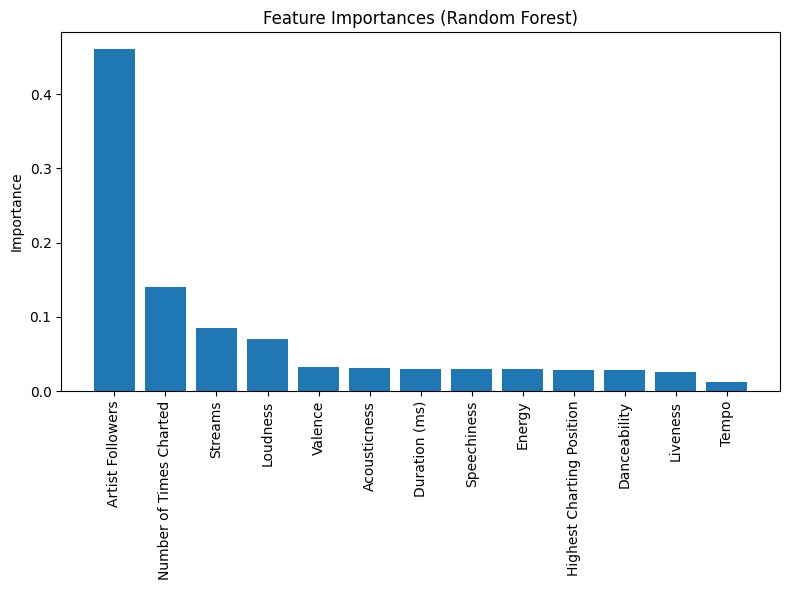

In [183]:
# 9. Plot feature importances for best model
best_name = res_df['test_rmse'].idxmin()
best_model = models[best_name][0].set_params(**results[best_name]['best_params'])
best_model.fit(X_train, y_train)

feat_imp = pd.Series(best_model.feature_importances_, index=numeric_features).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
plt.bar(feat_imp.index, feat_imp.values)
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title(f'Feature Importances ({best_name})')
plt.tight_layout()
plt.show()